In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import merged
import lightgbm as lgb
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, validation_curve, learning_curve, LearningCurveDisplay, ShuffleSplit
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

original = pd.read_csv("/kaggle/input/bank-marketing-dataset-full/bank-full.csv", sep=';')

In [3]:
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [4]:
df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')

# Initial classification
categorical = []
numerical = []
boolean = []

for col in df.columns:
    unique_vals = df[col].dropna().unique()
    if df[col].dtype == 'object':
        # Check if only 'yes'/'no' or 'true'/'false'
        if set(unique_vals).issubset({'yes', 'no', 'true', 'false', 'True', 'False'}):
            boolean.append(col)
        else:
            categorical.append(col)
    elif pd.api.types.is_numeric_dtype(df[col]):
        if len(unique_vals) == 2:
            boolean.append(col)
        else:
            numerical.append(col)
    else:
        categorical.append(col)

print("Categorical columns:", categorical)
print("Numerical columns:", numerical)
print("Boolean columns:", boolean)

Categorical columns: ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
Numerical columns: ['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Boolean columns: ['default', 'housing', 'loan', 'y']


In [5]:
Categorical_columns =  ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
Numerical_columns = ['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Boolean_columns = ['default', 'housing', 'loan', 'y']

In [6]:
train.shape

(750000, 18)

In [7]:
train.replace('unknown', np.nan, inplace=True)

<Axes: >

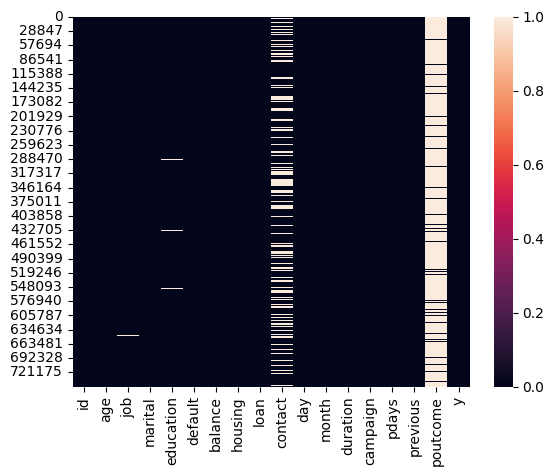

In [8]:
import seaborn as sns
sns.heatmap(train.isnull())

In [9]:
train.drop(['poutcome', 'contact'], axis=1, inplace=True, errors='ignore')


In [13]:
print("Unique values in original['y']:", original["y"].unique())
print("Unique values in train['y']:", train["y"].unique())

train = train.drop(columns=["id"])

original["y"] = original["y"].map({"no": 0, "yes": 1})

original = original[train.columns]

merged = pd.concat([train, original], ignore_index=True)

print("Merged shape:", merged.shape)
print("Merged target distribution:\n", merged["y"].value_counts())

Unique values in original['y']: ['no' 'yes']
Unique values in train['y']: [0 1]
Merged shape: (795211, 15)
Merged target distribution:
 y
0    699434
1     95777
Name: count, dtype: int64


In [14]:
print(merged.dtypes)

numeric_cols = merged.select_dtypes(include=["int64", "float64"]).columns.tolist()

categorical_cols = merged.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
y             int64
dtype: object
Numeric features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']
Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month']


In [15]:
missing_values = merged.isnull().sum()

missing_values = missing_values[missing_values > 0]

print("Missing values:\n", missing_values)

Missing values:
 job           2917
education    21299
dtype: int64


In [16]:
original["y"] = original["y"].map({"no": 0, "yes": 1})
original = original[train.columns]


In [17]:

merged = pd.concat([train, original], ignore_index=True)
print("Merged shape:", merged.shape)
print("Target distribution:\n", merged["y"].value_counts())

Merged shape: (795211, 15)
Target distribution:
 y
0.0    659512
1.0     90488
Name: count, dtype: int64


In [18]:
categorical_cols = merged.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    merged[col] = le.fit_transform(merged[col].astype(str))
    label_encoders[col] = le

X = merged.drop(columns=["y"])
y = merged["y"]

# Drop any rows where y is NaN
valid_idx = y.dropna().index
X = X.loc[valid_idx].reset_index(drop=True)
y = y.loc[valid_idx].reset_index(drop=True)

In [19]:
xgb_model = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

In [20]:
cat_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)

In [21]:
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1,
    n_estimators=2000, 
    learning_rate=0.05,
    min_child_samples=9,
    subsample=0.8,
    colsample_bytree=0.5,
    num_leaves=100,
    max_depth=10,
    max_bin=4523,
    reg_alpha=0.79,
    reg_lambda=3,
)

In [22]:
estimators = [
    ('xgb', xgb_model),
    ('cat', cat_model),
    ('lgb', lgb_model)
]

In [23]:
meta_model = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1,
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=8,
    reg_alpha=0.5,
    reg_lambda=1,
)

In [24]:
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
roc_scores = []
acc_scores = []

In [26]:
for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔷 Fold {fold} / {skf.get_n_splits()}")
    print("=" * 50)
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train the stacking model on this fold
    stack_model.fit(X_train, y_train)

    # Predict on validation fold
    preds_class = stack_model.predict(X_val)
    preds_proba = stack_model.predict_proba(X_val)[:, 1]

    # Compute metrics
    acc = accuracy_score(y_val, preds_class)
    auc = roc_auc_score(y_val, preds_proba)

    # Save scores
    acc_scores.append(acc)
    roc_scores.append(auc)

    print(f"📊 Fold {fold} Results:")
    print(f"   Accuracy: {acc:.4f}")
    print(f"   ROC AUC : {auc:.4f}")
    
    fold += 1

# ============================================================
# Summary after all folds
# ============================================================
print("\n================ Summary ================")
for i, (acc, auc) in enumerate(zip(acc_scores, roc_scores), 1):
    print(f"Fold {i}: Accuracy = {acc:.4f} | ROC AUC = {auc:.4f}")

print("----------------------------------------")
print(f"✅ Mean Accuracy: {np.mean(acc_scores):.4f}")
print(f"✅ Mean ROC AUC : {np.mean(roc_scores):.4f}")


🔷 Fold 1 / 5
📊 Fold 1 Results:
   Accuracy: 0.9418
   ROC AUC : 0.9726

🔷 Fold 2 / 5
📊 Fold 2 Results:
   Accuracy: 0.9406
   ROC AUC : 0.9713

🔷 Fold 3 / 5
📊 Fold 3 Results:
   Accuracy: 0.9410
   ROC AUC : 0.9712

🔷 Fold 4 / 5
📊 Fold 4 Results:
   Accuracy: 0.9417
   ROC AUC : 0.9722

🔷 Fold 5 / 5
📊 Fold 5 Results:
   Accuracy: 0.9412
   ROC AUC : 0.9716

================ Summary ================
Fold 1: Accuracy = 0.9418 | ROC AUC = 0.9726
Fold 2: Accuracy = 0.9406 | ROC AUC = 0.9713
Fold 3: Accuracy = 0.9410 | ROC AUC = 0.9712
Fold 4: Accuracy = 0.9417 | ROC AUC = 0.9722
Fold 5: Accuracy = 0.9412 | ROC AUC = 0.9716
----------------------------------------
✅ Mean Accuracy: 0.9413
✅ Mean ROC AUC : 0.9718


In [ ]:
stack_model.fit(X, y)


In [ ]:
test_id = test["id"]
test.drop(['poutcome', 'contact', 'id'], axis=1, inplace=True, errors='ignore')

In [ ]:
for col in categorical_cols:
    le = label_encoders[col]
    test[col] = le.transform(test[col].astype(str))

test_preds_proba = stack_model.predict_proba(test)[:, 1]

In [ ]:
submission = pd.DataFrame({
    "id": test_id,
    "y": test_preds_proba
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv file created successfully.")
